In [64]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, GRU, Dense, LSTM,SimpleRNN


In [27]:

import json
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')



In [130]:
df = getDF('D:\Download\Video_Games_5.json.gz')
df.iloc[0,4]
df=df.drop(['verified','reviewTime','summary','unixReviewTime','vote','style','image'],axis='columns',inplace=False)
df.dtypes

overall         float64
reviewerID       object
asin             object
reviewerName     object
reviewText       object
dtype: object

In [29]:
meta_data=getDF('D:\Download\meta_Video_Games.json.gz')
meta_data=meta_data.drop(['tech1','fit','tech2','feature','main_cat','price','details','imageURLHighRes','imageURL','price'],axis='columns',inplace=False)
meta_data.dtypes 

category        object
description     object
title           object
also_buy        object
brand           object
rank            object
also_view       object
similar_item    object
date            object
asin            object
dtype: object

In [30]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
       
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    


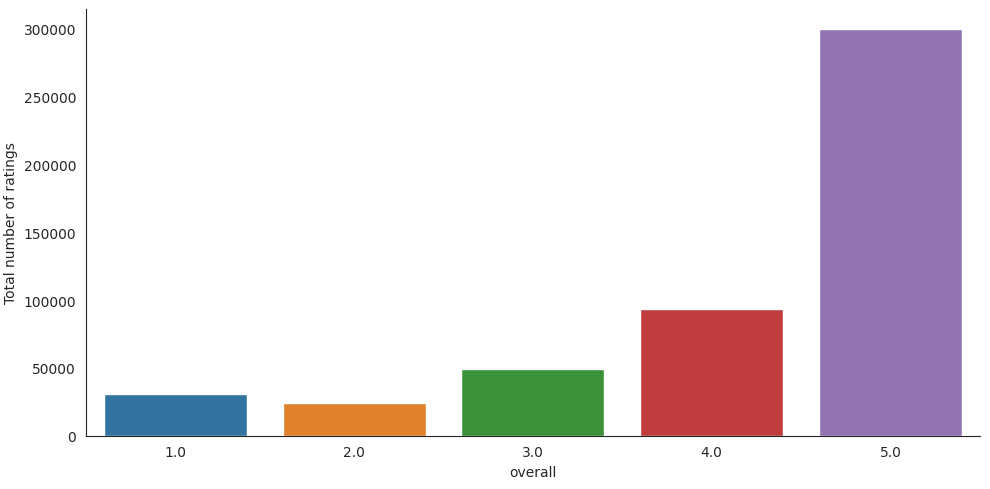

In [31]:

#plt.figure(figsize=(5,5))
#sorted_overal=df['overall'].value_counts().sort_index().plot(kind='bar').set_title('Bang phan bo danh gia')
import seaborn as sns
with sns.axes_style('white'):
    g = sns.catplot(x='overall',data=df,aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
plt.show()


In [32]:
df.describe()['overall'].T

count    497577.000000
mean          4.220456
std           1.185424
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [33]:
#Check for missing values
print('Number of missing values across columns: \n',df.isnull().sum())
#Dont worry cus they dont need a name


Number of missing values across columns: 
 overall           0
reviewerID        0
asin              0
reviewerName     76
reviewText      158
dtype: int64


In [34]:
from sklearn.preprocessing import LabelEncoder
#Deal with missing reviewText
# Replace missing review_text values with a placeholder string
df['reviewText'].fillna('No reviews', inplace=True)
le = LabelEncoder()
df['review_text_cat'] = le.fit_transform(df['reviewText'])
# Set the category value for rows with missing review_text
df.loc[df['reviewText'].isnull(), 'review_text_cat'] = -1



In [35]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.reviewerID)))
print("Total No of products  :", len(np.unique(df.asin)))

Total data 
--------------------------------------------------

Total no of ratings : 497577
Total No of Users   : 55223
Total No of products  : 17408


In [36]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = df.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

reviewerID
A3V6Z4RCDGRC44    815
AJKWF4W7QD4NS     795
A3W4D8XOGLWUN5    521
A2QHS1ZCIQOL7E    472
A2TCG2HV1VJP6V    453
Name: overall, dtype: int64

In [37]:
no_of_rated_products_per_user.describe()


count    55223.000000
mean         9.010322
std         10.704194
min          4.000000
25%          5.000000
50%          6.000000
75%          9.000000
max        815.000000
Name: overall, dtype: float64

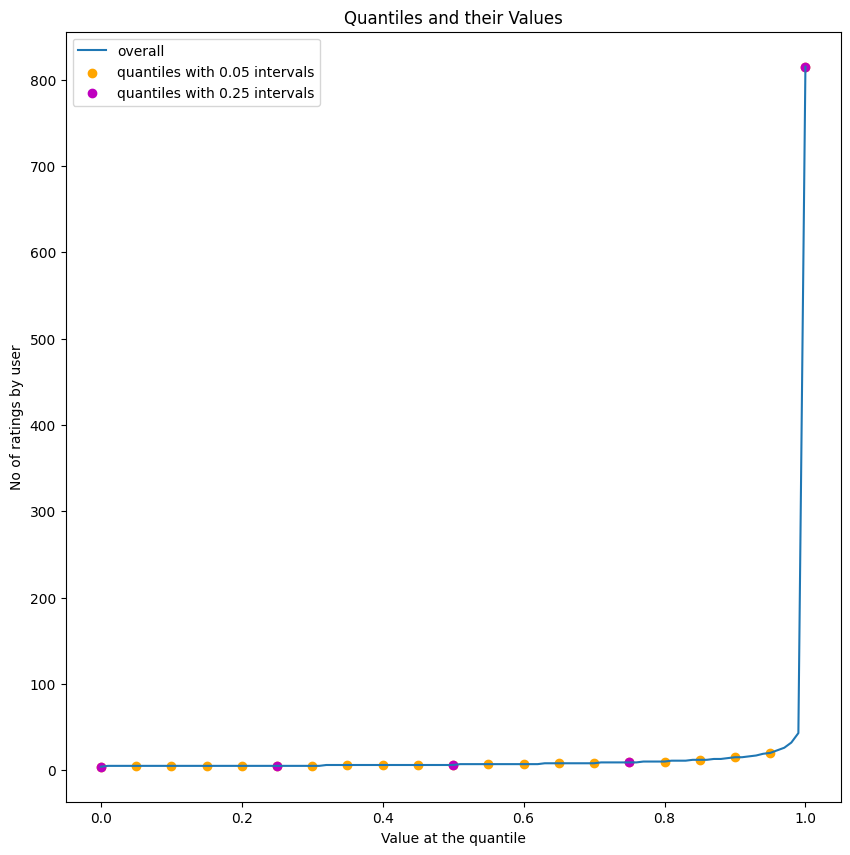

In [38]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()


In [39]:
new_df=df.groupby(by="reviewerID").filter(lambda x:x['overall'].count() >=50)
new_df.head

<bound method NDFrame.head of         overall      reviewerID        asin      reviewerName  \
5           4.0  A11V6ZJ2FVQY1D  0700026657    IBRAHIM ALBADI   
19          4.0  A2GPRA9HHLOC4B  0700026398       Wicasawakan   
23          4.0  A37AO20OXS51QA  0700026398  Roderic Rinehart   
39          4.0  A1QJJU33VNC4S7  0700099867            D@rkFX   
90          5.0  A1PSBR3JRZ9VO0  0804161380              Vdub   
...         ...             ...         ...               ...   
497465      5.0  A22M55ZQK96UK6  B01GW8W2TU    MAXTHEGAMER806   
497474      5.0   AG8UWL56LLU35  B01GW8ZC2O           Brandon   
497477      5.0  A22M55ZQK96UK6  B01GW8WPXI    MAXTHEGAMER806   
497540      2.0  A32JGNK1JNUSST  B01H3Z4MYE   Amazon Customer   
497573      3.0  A1RS06313BL6WN  B01HH6JEOC      Tom Stopsign   

                                               reviewText  review_text_cat  
5       i liked a lot some time that i haven't play a ...           377323  
19      I will open with the Pros:\

In [40]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, GRU, Dense, LSTM
# # Load and preprocess the data
# X = df['reviewText'].values
# y = df['overall'].values

# # Preprocess label data to remove outliers
# y = np.clip(y, 0, 4)

# # Encode label data as integers starting from 0
# y -= 1

# # Verify number of classes and set variables
# num_classes = len(np.unique(y))
# max_len = 100
# vocab_size = 20000

# # Tokenize the data and create sequences
# tokenizer = Tokenizer(num_words=vocab_size)
# tokenizer.fit_on_texts(X)
# X_seq = tokenizer.texts_to_sequences(X)
# X_pad = pad_sequences(X_seq, maxlen=max_len)

# # Split the data into training and testing sets
# split_ratio = 0.8
# split_index = int(split_ratio * len(X_pad))
# X_train = X_pad[:split_index]
# X_test = X_pad[split_index:]
# y_train = y[:split_index]
# y_test = y[split_index:]

# # Define the LSTM model architecture
# model = Sequential()
# model.add(Embedding(vocab_size, 128, input_length=max_len))
# model.add(LSTM(128))
# model.add(Dense(num_classes, activation='softmax'))

# # Train the model on the training data
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# # Evaluate the model on the testing data
# loss, acc = model.evaluate(X_test, y_test, verbose=0)
# print(f'Test loss: {loss}, Test accuracy: {acc}')

# # Make predictions on new data
# new_data = ['This product is amazing!', 'This product is terrible!']
# new_data_seq = tokenizer.texts_to_sequences(new_data)
# new_data_pad = pad_sequences(new_data_seq, maxlen=max_len)
# predictions = model.predict(new_data_pad)
# print(predictions)


In [ ]:
def title_asin(title):
    asin = meta_data.loc[meta_data['title'] == title, 'asin']
    if not asin.empty:
        return asin.values[0]
    else:
        return 'ASIN not found'
def asin_title(asin):
    title=meta_data.loc[meta_data['asin']==asin,'title']
    if not title.empty:
        return title.values[0]
    else:
        return 'title not found'
def asin_reviewText(Asin):
    reviewText=df.loc[df['asin']==Asin,'reviewText']
    if not reviewText.empty:
        return reviewText.values[0]
    else:
        return 'reviewText not found'
def asin_to_number(asin_list):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(asin_list)

def number_to_asin(asin_numbers):
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(df['asin'])
    return label_encoder.inverse_transform(asin_numbers)


In [77]:

#LSTM
# Preprocess the data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['reviewText'])
X = tokenizer.texts_to_sequences(df['reviewText'])
X = pad_sequences(X, maxlen=100)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['asin'])

# Define LSTM model architecture
model = Sequential()

model.add(Embedding(5000, 128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
#model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
Y=asin_to_number(df['asin'])
model.fit(X,Y, epochs=10, batch_size=32, validation_split=0.2)
model.save('modelLSTM.h5')



KeyboardInterrupt: 

In [95]:
#this code is to use model
def recommendations(asin, model, tokenizer, label_encoder, num_recommendations=5):
    # Get the review text for the input ASIN
    import tensorflow as tf
    
    input_review = df.loc[df['asin']==asin, 'reviewText'].values[0]
    
    # Convert review text to input sequence
    input_sequence = tokenizer.texts_to_sequences([input_review])
    input_sequence = pad_sequences(input_sequence, maxlen=100)
    
    # Use model to generate recommendations
    recommendations = model.predict(input_sequence)
    
    # Convert numerical labels back to ASINs
    recommendations_asin = label_encoder.inverse_transform(recommendations.flatten().astype(int))
    
    # Exclude input ASIN from recommendations
    recommendations_asin = recommendations_asin[recommendations_asin != asin]
    
    # Return top n recommendations
    return recommendations_asin[:num_recommendations]



In [111]:
def RecommendationASIN(input_asin):
    input_title=asin_title(input_asin)
    print(f'Input title:{input_title}')
    
    model=tf.keras.models.load_model('modelLSTM.h5')
    recommended_asins = recommendations(input_asin, model, tokenizer, label_encoder)
    print(recommended_asins)
    print(type(recommended_asins))
    count=0
    for i in recommended_asins:
        recommended_titles=[]
        recommended_titles.append(asin_title(recommended_asins[count]))
        print(f'Recommended_title: {recommended_titles[count]}')
        count=count+1
def RecommendationTitle(input_title):
    
    model=tf.keras.models.load_model('modelLSTM.h5')
    input_asin=title_asin(input_title)
    input_asin=np.array([input_asin])
    print(type(input_asin))
    recommended_asins = recommendations(input_asin, model, tokenizer, label_encoder)
    print(recommended_asins)
    count=0
    for i in recommended_asins:
        recommended_titles=[]
        recommended_titles.append(asin_title(recommended_asins[count]))
        print(f'Recommended_title: {recommended_titles[count]}')
        count=count+1


In [88]:
meta_data['title'][100]
meta_data['asin'][20]

'0439591570'

In [129]:
input_asin='6050036071'
imput_asin='0439591570'#
#RecommendationTitle('Cossacks Anthology - Collector s Edition')
RecommendationASIN(input_asin)
#print(asin_title(3936336512))

Input title:USB Microphone for RockBand or Guitar Hero (PS3, Wii, Xbox360)
1/1 [==============================] - 0s 320ms/step
['0700026657']
<class 'numpy.ndarray'>
Recommended_title: Anno 2070


In [115]:
input_asin='B00178630A'
#RecommendationTitle('Diablo III')
RecommendationASIN(input_asin)


Input title:Diablo III
1/1 [==============================] - 0s 334ms/step
['0700026657']
<class 'numpy.ndarray'>
Recommended_title: Anno 2070


In [128]:
meta_data.loc[meta_data['title']=='Anno 2070'][:10]

,category,description,title,also_buy,brand,rank,also_view,similar_item,date,asin
38,"[Video Games, PC, Games]",[ANNO 2070BRAND NEW - IN STOCKDVD Rom Software...,Anno 2070,[],Ubisoft,"[>#30,230 in Video Games (See Top 100 in Video...","[B013F0IP1C, B00JDP1AWU, B00XR3YC2E, B001AWMCM...",,,0700026657


In [ ]:
def Recommendation_title(Title):
    Asin=title_asin(title)
    loaded_model=tf.keras.model.load_model('model.h5')
    # Predict the sentiment of the review text for the matching ASIN
    Predictions = loaded_model.predict([Asin])
    

In [ ]:
Asin_Test=df.groupby(by='asin').count()
Asin_Test
df['asin'].head(40)

0     0700026657
1     0700026657
2     0700026657
3     0700026657
4     0700026657
5     0700026657
6     0700026657
7     0700026657
8     0700026657
9     0700026657
10    0700026657
11    0700026657
12    0700099867
13    0700099867
14    0700099867
15    0700099867
16    0700099867
17    0700026398
18    0700026398
19    0700026398
20    0700099867
21    0700026398
22    0700026398
23    0700026398
24    0700026398
25    0700099867
26    0700099867
27    0700099867
28    0700099867
29    0700099867
30    0700099867
31    0700099867
32    0700099867
33    0700099867
34    0700099867
35    0700099867
36    0700099867
37    0700099867
38    0700099867
39    0700099867
Name: asin, dtype: object

In [ ]:
meta_data['title']

0                               Reversi Sensory Challenger
1        Medal of Honor: Warfighter - Includes Battlefi...
2        street fighter 2 II turbo super nintendo snes ...
3                                       Xbox 360 MAS STICK
4                            Phonics Alive! 3: The Speller
                               ...                        
84814    Lego Star Wars: The Force Awakens - PS Vita [D...
84815    Lego Star Wars: The Force Awakens  Season Pass...
84816                The Technomancer - PS4 [Digital Code]
84817    Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...
84818    Zelotes 4000 DPI Programmable Gaming Mouse for...
Name: title, Length: 84819, dtype: object